# Clustering Multilingual Embeddings using LASER

In this tutorial, we'll explore the power of Language-Agnostic SEntence Representations ([LASER](https://github.com/facebookresearch/LASER)) for generating multilingual embeddings. We'll then use these embeddings to perform clustering on the [MASSIVE](https://github.com/alexa/massive) dataset. Our goal is to show that LASER embeddings can effectively group texts not only by their thematic content but also across different languages. LASER can encode sentences from multiple languages into a shared embedding space, allowing for cross-lingual understanding and comparison. We'll see how this capability is useful for tasks like multilingual clustering.


## Setting Up Your Environment

We will use the following libraries:
- `scikit-learn` for clustering algorithms and evaluation metrics.
- `plotly` for generating interactive plots.
- `laser_encoders` for generating text embeddings.
- `datasets` for downloading data from huggingface hub.


In [ ]:
!pip install -q laser_encoders datasets

In [ ]:
!pip install -U kaleido

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from laser_encoders import LaserEncoderPipeline

import datasets
from datasets import load_dataset

import warnings

warnings.filterwarnings("ignore")


## Loading the MASSIVE Dataset
We'll use the MASSIVE dataset, which includes texts in 52 languages. Let's load a subset of this dataset for our experiment:



In [ ]:
from datasets import load_dataset

n = 20
eng_data = load_dataset("AmazonScience/massive", "en-US", split=f'train[:{n}]')
fra_data = load_dataset("AmazonScience/massive", "fr-FR", split=f'train[:{n}]')
ita_data = load_dataset("AmazonScience/massive", "it-IT", split=f'train[:{n}]')
spa_data = load_dataset("AmazonScience/massive", "es-ES", split=f'train[:{n}]')
jap_data = load_dataset("AmazonScience/massive", "ja-JP", split=f'train[:{n}]')
arb_data = load_dataset("AmazonScience/massive", "ar-SA", split=f'train[:{n}]')
chn_data = load_dataset("AmazonScience/massive", "zh-CN", split=f'train[:{n}]')
afr_data = load_dataset("AmazonScience/massive", "af-ZA", split=f'train[:{n}]')
rus_data = load_dataset("AmazonScience/massive", "ru-RU", split=f'train[:{n}]')
hin_data = load_dataset("AmazonScience/massive", "hi-IN", split=f'train[:{n}]')

In [ ]:
data_dict = {
    "english": eng_data["utt"],
    "french": fra_data["utt"],
    "italian": ita_data["utt"],
    "spanish": spa_data["utt"],
    "japanese": jap_data["utt"],
    "arabic": arb_data["utt"],
    "chinese": chn_data["utt"],
    "afrikaans": afr_data["utt"],
    "russian": rus_data["utt"],
    "hindu": hin_data["utt"],
}

Here what the dataset looks like.

In [ ]:
for lang, texts in data_dict.items():
  print(f"{lang}: {texts[0]}")

english: wake me up at nine am on friday
french: réveille-moi à neuf heures du matin le vendredi
italian: svegliami alle nove di mattina venerdì
spanish: despiértame a las nueve de la mañana el viernes
japanese: 金曜日の午前九時に起こしてください
arabic: صحيني تسعة الصباح يوم الجمعة
chinese: 星期五早上九点叫醒我
afrikaans: maak my wakker nege-uur v. m. op vrydag
russian: разбуди меня в девять утра в пятницу
hindu: शुक्रवार को सुबह नौ बजे मुझे जगा दो


## Generating LASER Embeddings

We will encode our text data into embeddings using `laser_encoders`. This step is crucial as it translates our multilingual dataset into a uniform representation.



In [ ]:
combined_sentences = []
for senetence_list in data_dict.values():
    combined_sentences.extend(senetence_list)

print(f"All together we have {len(combined_sentences)} sentences")

All together we have 200 sentences


When we initialize the encoder with `lang='eng'`, it automatically defaults to using LASER 2, which offers support for nearly 100 languages.


In [ ]:
encoder = LaserEncoderPipeline(lang="eng")
embeddings = encoder.encode_sentences(combined_sentences, normalize_embeddings=True)

## Clustering with Multilingual Embeddings
With our LASER embeddings, we can now apply a clustering algorithm. K-Means is a good starting point for its simplicity and effectiveness:

## Choice of number of clusters.
In our case, we have `20` parallel sentences in each of 5 languages, meaning these sentences convey the same meanings or topics in different languages. If each sentence represents a unique topic or thematic content, then ideally, We would expect to see around 20 clusters. This is because LASER is designed to map semantically similar sentences to nearby points in the embedding space, regardless of the language.

In [ ]:
n_clusters = 20
kmeans = KMeans(n_clusters=20, random_state=42)
clusters = kmeans.fit_predict(embeddings)

## Reduce Dimensionality for Visualization

We'll use t-SNE to reduce the dimensionality of our embeddings so we can plot them in 2D:



In [ ]:
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

## Evaluating Clustering Performance
To evaluate our clustering, we'll use metrics suited for clustering quality, such as the Adjusted Rand Index (ARI), Normalized Mutual Information Score and Silhouette Coefficient:



In [ ]:
from sklearn.metrics import rand_score,adjusted_rand_score, normalized_mutual_info_score, silhouette_score

labels = list(range(20)) * len(data_dict)

ri_score = rand_score(labels, clusters)
ari_score = adjusted_rand_score(labels, clusters)
nmi_score = normalized_mutual_info_score(labels, clusters, average_method='arithmetic')
silhouette_avg = silhouette_score(embeddings, clusters)

print(f"Rand Index: {ri_score}")
print(f"Adjusted Rand Index: {ari_score}")
print(f"Normalized Mutual Information: {nmi_score}")
print(f"Silhouette Coefficient: {silhouette_avg}")


Rand Index: 0.9731155778894472
Adjusted Rand Index: 0.7050871871580726
Normalized Mutual Information: 0.862654325567496
Silhouette Coefficient: 0.22755876183509827


## Clustering Evaluation Summary with LASER Embeddings

We evaluated our clustering model, which leverages LASER embeddings, with the following results:

- **Rand Index (RI):** 0.973 - High accuracy, indicating successful clustering.
- **Adjusted Rand Index (ARI):** 0.705 - Shows good performance, considering the adjustment for random chance.
- **Normalized Mutual Information (NMI):** 0.862 - Demonstrates strong alignment between our clustering and the true labels.
- **Silhouette Coefficient:** 0.227 - Suggests moderate cluster separation.

### Role of LASER in Clustering Performance

The effectiveness of our clustering, as evidenced by the high RI, ARI, and NMI scores, can be significantly attributed to the LASER embeddings. LASER's ability to create language-agnostic sentence representations has likely enhanced the clustering quality, enabling the algorithm to group sentences based on semantic similarity across different languages. This is further supported by the reasonable Silhouette Coefficient, indicating decent separation between clusters. These results showcase LASER’s capability in handling multilingual data.


## Prepare Data for Plotting
We organize our data for easy ploting using `plotly`:

In [ ]:
languages = []
for lang, sentence in data_dict.items():
  languages.extend([lang] * len(sentence))

# Create a DataFrame for plotting
df = pd.DataFrame({
    'TSNE Component 1': reduced_embeddings[:, 0],
    'TSNE Component 2': reduced_embeddings[:, 1],
    'Language': languages,
    'Cluster': ['Cluster {}'.format(cluster) for cluster in clusters],
    'Sentence': combined_sentences
})


## Plot Using Plotly
Le's then go ahead to create an interactive scatter plot:

In [ ]:
import plotly.express as px
import plotly.graph_objects as go


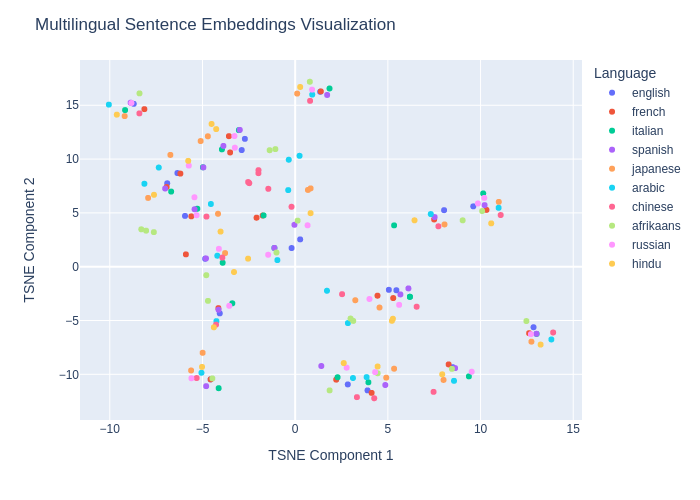

In [ ]:
fig = px.scatter(df, x='TSNE Component 1', y='TSNE Component 2', color='Language',
                 hover_data=['Sentence'])
fig.update_layout(title="Multilingual Sentence Embeddings Visualization",
                  xaxis_title="TSNE Component 1", yaxis_title="TSNE Component 2",
                  legend_title="Language")
fig.show("png") #for interactive plots use fig.show()


In [ ]:
num_languages = len(data_dict)  # Number of languages
num_sentences = len(reduced_embeddings) // num_languages

cluster_centers = np.array([np.mean(reduced_embeddings[i::num_sentences], axis=0) for i in range(num_sentences)])

Let's try to draw circles to distinguish the clusters.

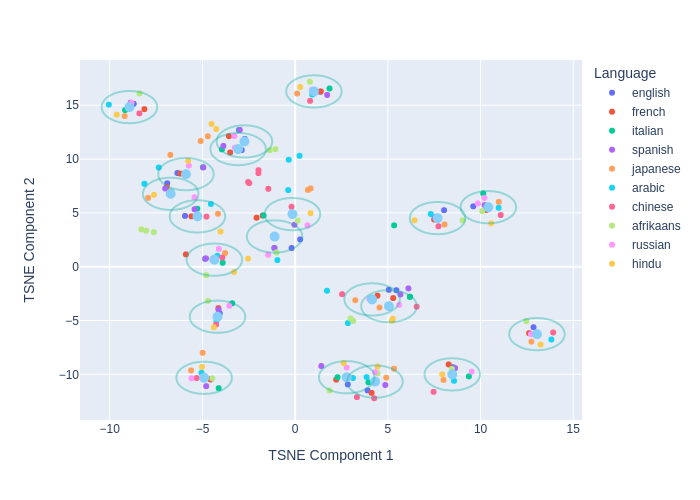

In [ ]:
radius = 1.5
# Your existing code for the scatter plot
fig = px.scatter(df, x='TSNE Component 1', y='TSNE Component 2', color='Language',
                hover_data=['Sentence'])
# Add circles
for center in cluster_centers:
    fig.add_trace(go.Scatter(x=[center[0]], y=[center[1]],
                             mode='markers',
                             marker=dict(size=10, color='LightSkyBlue'),
                             showlegend=False))
    fig.add_shape(type="circle",
                  xref="x", yref="y",
                  x0=center[0] - radius, y0=center[1] - radius,
                  x1=center[0] + radius, y1=center[1] + radius,
                  line_color="LightSeaGreen", opacity=0.4
                 )

fig.show("png") #for interactive plots use fig.show()

## Conclusion.

In this tutorial, we explored how to perform multilingual text clustering using the MASSIVE dataset. We loaded the text data, applied K-Means clustering, and evaluated our clusters using differnet clustering performance evaluation metrics. The visualization and analysis helped us understand the efficacy of LASER across different languages.